# Import relevant libraries

In [1]:
import os
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [6]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [10]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [11]:
perf_eval_df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Ajax,out,0.817,1992
...,...,...,...,...,...,...,...
27313,Sevilla FC,Oussama Idrissi,24.0,AZ Alkmaar,in,10.800,2020
27314,Sevilla FC,Karim Rekik,25.0,Hertha BSC,in,1.800,2020
27315,Athletic Bilbao,Álex Berenguer,25.0,Torino,in,9.450,2020
27316,Granada CF,Luis Suárez,22.0,Watford,in,6.300,2020


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [12]:
fee_age = perf_eval_df[['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
0,19.0,0.817
1,21.0,0.013
2,25.0,1.170
3,21.0,0.005
4,19.0,0.817
...,...,...
27313,24.0,10.800
27314,25.0,1.800
27315,25.0,9.450
27316,22.0,6.300


<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

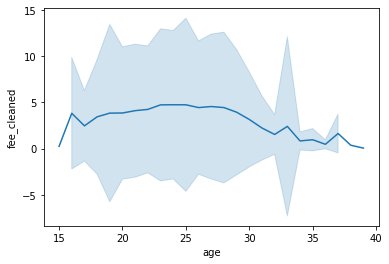

In [13]:
# the variance is quite high
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 'sd')

<AxesSubplot:xlabel='fee_cleaned', ylabel='Count'>

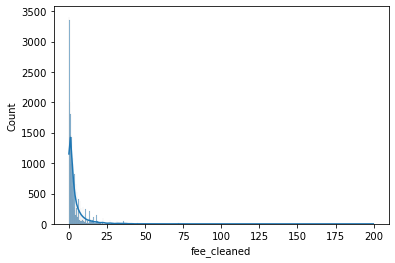

In [14]:
# heavy-tailed distribution --> median would be a more sensible mid-point measure
# as mean would be influenced by the outliers
sns.histplot(fee_age['fee_cleaned'], kde = True)

In [15]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 30]

In [16]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
16.0,3.826818,0.675,6.046290,0.023,18.81,33
17.0,2.461075,0.990,3.822797,0.005,21.60,147
18.0,3.438588,1.350,6.208838,0.002,40.50,529
19.0,3.842180,1.350,9.616844,0.005,130.50,1074
20.0,3.853751,1.555,7.177449,0.009,124.20,1648
21.0,4.108022,1.570,7.212380,0.005,79.38,2232
22.0,4.245957,1.780,6.882831,0.004,67.50,2608
23.0,4.736817,1.905,8.249350,0.009,94.50,2880
24.0,4.748181,2.030,8.050826,0.008,90.90,2849


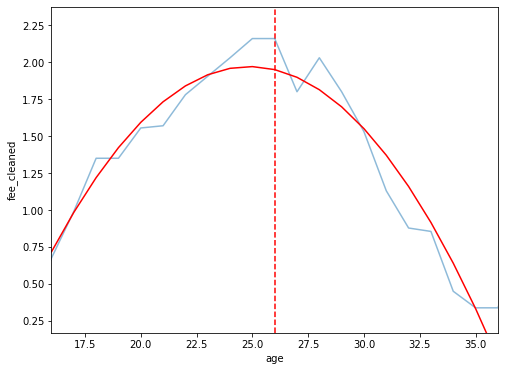

In [20]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0 + 1]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [14]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index, 
                               'coef': coef})
temp_df

,age,coef
0,17.0,1.000000
1,18.0,0.759470
2,19.0,0.628703
3,20.0,0.548965
4,21.0,0.497560
5,22.0,0.464002
6,23.0,0.442931
7,24.0,0.431524
8,25.0,0.428409
9,26.0,0.433233


In [15]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.759470
4,19.0,0.628703
5,20.0,0.548965
6,21.0,0.497560
7,22.0,0.464002
8,23.0,0.442931
9,24.0,0.431524


## Homophily-Performance Analysis

In [16]:
node_edge_df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,René Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [17]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_involved_name'].unique())

In [18]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [19]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):
    
    if prev_year in nested_dict.keys():
        
        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])
    
    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}
    
    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]
    
    # subset for transfer_movement == 'in', 'out'
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']
        
    # loop over club:
    for club in club_list:
        
        # subset data by club
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]
        
        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])
        
        if prev_year in nested_dict.keys():
            
            # catch bug
            if club_member[club] is None:
                club_member[club] = []
            
            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)
            
        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in, player_list_out)
            
    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member
    
    # set previous year
    prev_year = year

### Performance Analysis (Fee)

In [20]:
perf_eval_df.head()

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year
0,Ajax Amsterdam,Marc Overmars,19.0,Willem II,in,0.817,1992
1,Ajax Amsterdam,Jari Litmanen,21.0,MYPA,in,0.013,1992
2,Ajax Amsterdam,Aron Winter,25.0,Lazio,out,1.170,1992
3,Sparta Rotterdam,Winston Bogarde,21.0,Excelsior,in,0.005,1992
4,Willem II Tilburg,Marc Overmars,19.0,Ajax,out,0.817,1992


In [21]:
adj_coef_table.head()

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.759470
4,19.0,0.628703


In [22]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on = 'age', how = 'left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'], perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns = 'coef', inplace = True)
perf_eval_df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee
0,Ajax Amsterdam,Marc Overmars,19.0,Willem II,in,0.817,1992,0.513650
1,Ajax Amsterdam,Jari Litmanen,21.0,MYPA,in,0.013,1992,0.006468
2,Ajax Amsterdam,Aron Winter,25.0,Lazio,out,1.170,1992,0.501239
3,Sparta Rotterdam,Winston Bogarde,21.0,Excelsior,in,0.005,1992,0.002488
4,Willem II Tilburg,Marc Overmars,19.0,Ajax,out,0.817,1992,0.513650
...,...,...,...,...,...,...,...,...
27313,Sevilla FC,Oussama Idrissi,24.0,AZ Alkmaar,in,10.800,2020,4.660455
27314,Sevilla FC,Karim Rekik,25.0,Hertha BSC,in,1.800,2020,0.771136
27315,Athletic Bilbao,Álex Berenguer,25.0,Torino,in,9.450,2020,4.048466
27316,Granada CF,Luis Suárez,22.0,Watford,in,6.300,2020,2.923211


In [24]:
# subset only `transfer_movement` == 'in' to avoid double counting
df = perf_eval_df[perf_eval_df['transfer_movement'] == 'in']
df.reset_index(drop = True, inplace = True)
# clean the table
df.drop_duplicates(inplace = True)

In [25]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
df.drop(columns = 'count', inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Ajax Amsterdam,Marc Overmars,19.0,Willem II,in,0.817,1992,0.513650,1,3
1,Ajax Amsterdam,Jari Litmanen,21.0,MYPA,in,0.013,1992,0.006468,1,2
2,Sparta Rotterdam,Winston Bogarde,21.0,Excelsior,in,0.005,1992,0.002488,1,3
3,PSV Eindhoven,Arthur Numan,22.0,Twente FC,in,1.150,1992,0.533602,1,1
4,Feyenoord Rotterdam,Michael Obiku,23.0,Anorthosis,in,0.327,1992,0.144839,1,1
...,...,...,...,...,...,...,...,...,...,...
15893,SD Huesca,Dimitrios Siovas,32.0,CD Leganés,in,0.900,2020,0.718444,2,2
15894,SD Huesca,Andrés Fernández,33.0,Villarreal,in,0.450,2020,0.485511,3,3
15895,Celta de Vigo,Miguel Baeza,20.0,RM Castilla,in,2.250,2020,1.235171,1,1
15896,Elche CF,Raúl Guti,23.0,Real Zaragoza,in,4.500,2020,1.993191,1,1


In [26]:
# only select the players that have at least two transfers to see the improvement
target_player = list(df[df['num_transfer'] > 1]['player_name'])

df = df[df['player_name'].isin(target_player)]
df.reset_index(drop = True, inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Ajax Amsterdam,Marc Overmars,19.0,Willem II,in,0.817,1992,0.513650,1,3
1,Ajax Amsterdam,Jari Litmanen,21.0,MYPA,in,0.013,1992,0.006468,1,2
2,Sparta Rotterdam,Winston Bogarde,21.0,Excelsior,in,0.005,1992,0.002488,1,3
3,Ajax Amsterdam,Ronald de Boer,22.0,Twente FC,in,1.230,1992,0.570722,1,2
4,Cambuur-Leeuwarden bvo,Bert Konterman,21.0,FC Zwolle,in,0.122,1992,0.060702,1,2
...,...,...,...,...,...,...,...,...,...,...
9039,Cádiz CF,Choco Lozano,27.0,Girona,in,2.250,2020,1.004733,2,2
9040,Cádiz CF,Iván Alejo,25.0,Getafe,in,1.800,2020,0.771136,3,3
9041,Cádiz CF,Filip Malbašić,27.0,CD Tenerife,in,0.900,2020,0.401893,2,2
9042,SD Huesca,Dimitrios Siovas,32.0,CD Leganés,in,0.900,2020,0.718444,2,2


In [27]:
# get player_list
player_list = list(df['player_name'].unique())

In [28]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):
    
    # subset df by player
    temp_df = df[df['player_name'] == player]
    
    # reset_index
    temp_df.reset_index(drop = True, inplace = True)
    
    # initiate inside dictionaries
    aff_clubs = {}
    
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """
    
    for row in range(len(temp_df) - 1):
        
        # initiate inside dictionaries
        year_member = {}
        
        club_involved_name = temp_df.iloc[row]['club_involved_name']
        
        year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])
        
        # get the affiliated player each year from `nested_dict`
        for year in year_list:
            
            aff_players = nested_dict[year][club_involved_name]
            
            # add data to `year_member`
            year_member[year] = aff_players
      
        # add data to aff_club 
        
        # adjust for the case when player moves back to the club he's been before
        if club_involved_name in aff_clubs.keys():
            
                aff_clubs[club_involved_name].update(year_member)
            
        else:
            
            aff_clubs[club_involved_name] = year_member
            
    # add data to was_in
    was_in[player] = aff_clubs

In [29]:
was_in

{'Marc Overmars': {'Willem II': {1992: [],
   1993: [],
   1994: [],
   1995: [],
   1996: []},
  'Ajax': {1997: [], 1998: [], 1999: []}},
 'Jari Litmanen': {'MYPA': {1992: [],
   1993: [],
   1994: [],
   1995: [],
   1996: [],
   1997: [],
   1998: []}},
 'Winston Bogarde': {'Excelsior': {1992: [], 1993: []},
  'Sparta R.': {1994: [], 1995: [], 1996: []}},
 'Ronald de Boer': {'Twente FC': {1992: [],
   1993: [],
   1994: [],
   1995: [],
   1996: [],
   1997: []}},
 'Bert Konterman': {'FC Zwolle': {1992: [],
   1993: [],
   1994: [],
   1995: [],
   1996: []}},
 'David Rocastle': {'Arsenal': {1992: []}, 'Leeds': {1993: []}},
 'David Kerslake': {'Swindon Town': {1992: []}},
 'Kevin Sharp': {'AJ Auxerre': {1992: ['Moussa Saïb',
    'Frank Verlaat',
    'Lilian Laslandes',
    'Thierry Bonalair',
    'Bernard Diomède',
    'Jacques-Désiré Périatambée',
    'Franck Rabarivony',
    'Fabien Cool',
    'Laurent Ciechelski'],
   1993: ['Moussa Saïb',
    'Frank Verlaat',
    'Lilian Lasland

In [30]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace = True)
df.reset_index(drop = True, inplace = True)
df

,club_name,player_name,age,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee,num_transfer,max_transfer
0,Leeds United,Aapo Halme,19.0,HJK Helsinki,in,0.504,2017,0.316866,1,2
1,Barnsley FC,Aapo Halme,21.0,Leeds,in,0.203,2019,0.101005,2,2
2,Ipswich Town,Aaron Cresswell,21.0,Tranmere Rovers,in,0.248,2011,0.123395,1,2
3,West Ham United,Aaron Cresswell,24.0,Ipswich,in,4.280,2014,1.846921,2,2
4,Aston Villa,Aaron Hughes,25.0,Newcastle,in,1.350,2005,0.578352,1,2
...,...,...,...,...,...,...,...,...,...,...
9039,Liverpool FC,Öyvind Leonhardsen,26.0,Wimbledon FC,in,4.730,1997,2.049191,2,3
9040,Tottenham Hotspur,Öyvind Leonhardsen,28.0,Liverpool,in,4.050,1999,1.903431,3,3
9041,Milan AC,Ümit Davala,28.0,Galatasaray,in,4.500,2001,2.114924,1,3
9042,FC Internazionale,Ümit Davala,28.0,Milan,in,1.800,2002,0.845969,2,3


In [31]:
# generate `k` column

# initiate a list
k = []

# loop over the dataset
for i in tqdm(range(len(df))):
    
    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:  
        
        k.append(None)
        
    else:  
        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_involved_name'][i-1]
        club = df['club_involved_name'][i]
        prev_year = df['year'][i-1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)
        
        # get all the affiliated players
        aff_players = []
        for year in year_range:
            aff_player = was_in[player][prev_club][year]
            aff_players.extend(aff_player)
        
        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]
        
        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))
        
        # get `k_val`
        k_val = len(set.intersection(set(aff_players), set(in_club_player)))
        
        # append `k_val` to `k`
        k.append(k_val)
        
        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k

In [32]:
# change in adjusted fee as a proxy of performance --> `perf_change
df['perf_change'] = df.groupby('player_name')['adjusted_fee'].pct_change()

In [33]:
# get `k-perf` table
k_perf = df[['k', 'perf_change']].dropna()
k_perf

,k,perf_change
1,0.0,-0.681238
3,0.0,13.967551
5,0.0,0.042340
7,0.0,2.094150
8,0.0,-0.660533
...,...,...
9037,0.0,2.104452
9039,0.0,4.408582
9040,0.0,-0.071130
9042,0.0,-0.600000


In [34]:
k_perf.sort_values(by = 'k', ascending = False)

,k,perf_change
7235,58.0,1.200733
5139,57.0,0.552226
1781,56.0,-0.806423
5112,32.0,-0.937505
3067,26.0,-0.400945
...,...,...
3052,0.0,-0.263762
3051,0.0,3.227293
3049,0.0,-0.207291
3047,0.0,-0.281554


In [35]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median', 'count'])).reset_index()

,k,median,count
0,0.0,0.252361,5300
1,1.0,0.450820,123
2,2.0,0.593150,22
3,3.0,0.063289,6
4,4.0,0.381354,3
5,5.0,0.364452,2
6,6.0,8.021042,1
7,8.0,-0.027760,2
8,9.0,2.658505,1
9,10.0,0.464179,3


In [36]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['mean', 'median', 'count'])).reset_index()
k = table['k']
perf_change = table['median']

In [37]:
table

,k,mean,median,count
0,0.0,3.139815,0.252361,5300
1,1.0,2.922272,0.450820,123
2,2.0,2.777319,0.593150,22
3,3.0,3.060195,0.063289,6
4,4.0,-0.046021,0.381354,3
5,5.0,0.364452,0.364452,2
6,6.0,8.021042,8.021042,1
7,8.0,-0.027760,-0.027760,2
8,9.0,2.658505,2.658505,1
9,10.0,1.362660,0.464179,3


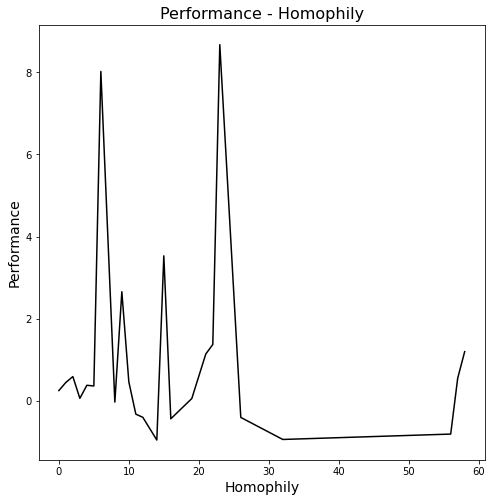

In [38]:
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel('Homophily', size = 14)
ax.set_ylabel('Performance', size = 14)
ax.set_title('Performance - Homophily', size = 16)

ax.plot(k, perf_change, color = 'black')



plt.show()